<a href="https://colab.research.google.com/github/BIJESHPATEL369/CSCE-5290-Natural-Language-Processing-Project/blob/main/Increment_2_Task_2_Muticlass_Product_Classification_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INCREMENT 2 :Task 2 : MULTICLASS PRODUCT CLASSIFICATION

# Install Packages

In [ ]:
#NLTK package to dowload the stop words, import PorterStemmer.
!pip install nltk

#Tensor flow to downlad the Universel sentence encoder for embedding the text.
!pip install tensorflow_text 

# install tarnsformers
!pip install transformers

# install sentencepiece
!pip install sentencepiece

# To download dataset from google drive
!pip install gdown

     |████████████████████████████████| 4.9 MB 8.8 MB/s 
     |████████████████████████████████| 462 kB 62.8 MB/s 
     |████████████████████████████████| 4.0 MB 7.9 MB/s 
     |████████████████████████████████| 596 kB 54.1 MB/s 
     |████████████████████████████████| 6.6 MB 48.4 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 880 kB 47.6 MB/s 
     |████████████████████████████████| 96 kB 6.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.50-py3-none-any.whl size=895166 sha256=75531d819e9a1d32c2b6550aa7294f5ff2476116e56588293b38e9ea41489e94
  Stored in directory: /root/.cache/pip/wheels/d9/72/54/519f0d5143cc6c73fa3297509123c86fc8586a7fdea8d25311
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling clic

# Import Libraries

In [ ]:
import pandas as pd
import re
import string 
import numpy as np
import time

# pre-processing the input features
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer

# order the feature text for removing duplicates
from collections import OrderedDict

#convert the string text to vector representation
import tensorflow_hub as hub
import tensorflow_text
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf

# To create traning and test dataset
from sklearn.model_selection import train_test_split

# Shuffle data
from sklearn.utils import shuffle

# Loading the model
from sklearn.ensemble import RandomForestClassifier

# Evaluate the model accuaracy
from sklearn.metrics import accuracy_score, classification_report

# Ploting the data analyisis
import matplotlib.pyplot as plt

# data preparation
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
import pickle
import os

# import training model requirments
from transformers import AlbertTokenizer, BertTokenizer, BertForSequenceClassification, AdamW, AlbertForSequenceClassification

# Evaluation report
from sklearn.metrics import classification_report

# device set up
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
cuda:0


# Loading Data sets

Reading the Product catalog and train data datasets

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1ezO5qJSDfzUd4V9FjYnAD3hCXCeTM2uh?usp=sharing 

Retrieving folder list
Processing file 1AP8O8TaFpx7u2NUNMrOAVQeMbEP2YKC7 albert_epoch4_may1_12:25.pth
Processing file 1xbjc9Ue1CHQdhOjaeJCEhn-Ke6dLCMg0 bert_epoch4_May1_4:16pm.pth
Processing file 1OSVaAdLldXYgbE28ySk3AZpYROTxinBl product_catalogue-v0.2.csv
Processing file 1BYNgwWuz_w-7CtCBzrlEUFiJ7DC0VyGB sample_submission-v0.2.csv
Processing file 14Zk3b7HQ-oICLkog0jYI6AGQdCPMFGGJ test_public-v0.2.csv
Processing file 1PV5DCqZS9KyOSdQNENjAu3rXb4bsko7K train-v0.2.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1AP8O8TaFpx7u2NUNMrOAVQeMbEP2YKC7
To: /content/Dataset csv/albert_epoch4_may1_12:25.pth
100% 46.8M/46.8M [00:00<00:00, 234MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xbjc9Ue1CHQdhOjaeJCEhn-Ke6dLCMg0
To: /content/Dataset csv/bert_epoch4_May1_4:16pm.pth
100% 438M/438M [00:03<00:00, 112MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OSVaAdLldXYgbE28ySk

In [ ]:
# Reading the Product catalog and train data datasets
product_catalog_pd = pd.read_csv('/content/Dataset csv/product_catalogue-v0.2.csv')
train_pd = pd.read_csv('/content/Dataset csv/train-v0.2.csv')
test_public_pd = pd.read_csv('/content/Dataset csv/test_public-v0.2.csv')
sample_submission_pd = pd.read_csv('/content/Dataset csv/sample_submission-v0.2.csv')

In [ ]:
print(product_catalog_pd["product_locale"].unique())

# Select 'US' Locale from both train and product catalog dataset
us_product_catalog_pd = product_catalog_pd.loc[product_catalog_pd['product_locale'] == 'us']
us_train_pd = train_pd.loc[train_pd['query_locale'] == 'us']

['es' 'us' 'jp']


In [ ]:
us_train_pd

,example_id,query,product_id,query_locale,esci_label
249721,249721,revent 80 cfm,B000MOO21W,us,irrelevant
249722,249722,revent 80 cfm,B001E6DMKY,us,exact
249723,249723,revent 80 cfm,B003O0MNGC,us,exact
249724,249724,revent 80 cfm,B00MARNO5Y,us,exact
249725,249725,revent 80 cfm,B00XBZFWWM,us,exact
...,...,...,...,...,...
1522342,1522342,zephyr polishing kit,B081SYK6R2,us,irrelevant
1522343,1522343,zephyr polishing kit,B087HZQY4V,us,complement
1522344,1522344,zephyr polishing kit,B08H4ZJ6Q1,us,substitute
1522345,1522345,zephyr polishing kit,B08LSN8MT8,us,substitute


In [ ]:
us_test_public_pd = test_public_pd.loc[test_public_pd['query_locale'] == 'us']

In [ ]:
us_test_public_pd

,example_id,query,product_id,query_locale
53494,2280865,#1 small corded treadmill without remote control,B00QIM5CMK,us
53495,2280866,#1 small corded treadmill without remote control,B0193V3DJ6,us
53496,2280867,#1 small corded treadmill without remote control,B07KTSR8MP,us
53497,2280868,#1 small corded treadmill without remote control,B07MW21KMZ,us
53498,2280869,#1 small corded treadmill without remote control,B07SJCZLPQ,us
...,...,...,...,...
327750,2555121,xl tall moisture wicking shirt,B08XX3NL14,us
327751,2555122,xl tall moisture wicking shirt,B08Y8M9Z6L,us
327752,2555123,xl tall moisture wicking shirt,B0936FKSS6,us
327753,2555124,xl tall moisture wicking shirt,B096RXY1VT,us


In [ ]:
us_train_pd.esci_label.value_counts()

exact         874058
substitute    257735
irrelevant    112618
complement     28215
Name: esci_label, dtype: int64

# Data Description

**Product Catalog dataset**

In [ ]:
us_product_catalog_pd.head(3)

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color_name,product_locale
167236,B003O0MNGC,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,NaN,Virtually silent at less than 0.3 sones\nPreci...,DELTA ELECTRONICS (AMERICAS) LTD.,White,us
167237,B00MARNO5Y,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,NaN,Super quiet 80CFM energy efficient fan virtual...,Aero Pure,White,us
167238,B011RX6PNO,Aero Pure AP120H-SL W Slim Fit 120 CFM Bathroo...,NaN,"Slim Fit Housing Fits Into 2"" X 6"" Ceiling Joi...",Aero Pure,White Finish,us


**Train dataset**

In [ ]:
us_train_pd.head(5)

,example_id,query,product_id,query_locale,esci_label
249721,249721,revent 80 cfm,B000MOO21W,us,irrelevant
249722,249722,revent 80 cfm,B001E6DMKY,us,exact
249723,249723,revent 80 cfm,B003O0MNGC,us,exact
249724,249724,revent 80 cfm,B00MARNO5Y,us,exact
249725,249725,revent 80 cfm,B00XBZFWWM,us,exact


**Product catalog and Train dataset info**

In [ ]:
print("Product catalog: \n")
us_product_catalog_pd.info()
print("\n \n")
print("Train: \n")
us_train_pd.info()

Product catalog: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216070 entries, 167236 to 1753643
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   product_id            1216070 non-null  object
 1   product_title         1215854 non-null  object
 2   product_description   646076 non-null   object
 3   product_bullet_point  1037091 non-null  object
 4   product_brand         1143575 non-null  object
 5   product_color_name    809776 non-null   object
 6   product_locale        1216070 non-null  object
dtypes: object(7)
memory usage: 74.2+ MB

 

Train: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1272626 entries, 249721 to 1522346
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   example_id    1272626 non-null  int64 
 1   query         1272626 non-null  object
 2   product_id    1272626 non-null  object
 3   

**Product catalog describe**

In [ ]:
us_product_catalog_pd.describe(include='object')

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color_name,product_locale
count,1216070,1215854,646076,1037091,1143575,809776,1216070
unique,1216070,1193661,541651,861808,211177,175308,1
top,B003O0MNGC,Episode 1,This pre-owned or refurbished product has been...,Used Book in Good Condition,Nike,Black,us
freq,1,152,1192,2718,6160,125444,1216070


**Train dataset describe**

In [ ]:
us_train_pd.describe(include='object')

,query,product_id,query_locale,esci_label
count,1272626,1272626,1272626,1272626
unique,68139,913438,1,4
top,tv,B01HFFXLNA,us,exact
freq,198,88,1272626,874058


# Design of features

In [ ]:
# Join the product catalog and train dataset based on product id
us_train_product_df = us_train_pd.merge(us_product_catalog_pd,left_on = ['product_id'],right_on=['product_id'], how= 'left')

#Combine Product Catalog Text into one column
columns = ['product_title', 'product_brand', 'product_color_name']
us_train_product_df['product_text'] = us_train_product_df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Feature selection
us_train_product_modified_df = us_train_product_df[['example_id', 'query', 'product_id','esci_label', 'product_text']].copy()

In [ ]:
# shuffle data
us_train_product_modified_df = shuffle(us_train_product_modified_df)

# data sampling
us_train_product_modified_sampe_df = us_train_product_modified_df.sample(n = 250000)

# Data Cleaning

**Apply Preprocessing**

In [ ]:
stop_words = stopwords.words('english')
# Stemmer = PorterStemmer()
table = str.maketrans('', '', string.punctuation)

def data_cleaning(text):
  texts = re.sub("[^a-zA-Z]", " ", text)
  texts = [texts.lower() for texts in text.split() if texts.lower() not in stop_words]
  # texts = [Stemmer.stem(t) for t in texts]
  texts = [t.translate(table) for t in texts]
  return " ".join(texts)

# data cleaning
us_train_product_modified_sampe_df['query'] = us_train_product_modified_sampe_df['query'].apply(data_cleaning)
us_train_product_modified_sampe_df['product_text'] = us_train_product_modified_sampe_df['product_text'].apply(data_cleaning)

In [ ]:
# remove duplicate words form product text
us_train_product_modified_sampe_df['product_text_modified'] = (us_train_product_modified_sampe_df['product_text'].str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))
us_train_product_modified_sampe_df

,example_id,query,product_id,esci_label,product_text,product_text_modified
409188,658909,gender reveal smoke bombs,B07XH2LXBS,exact,gender reveal confetti powder mix cannons 36 i...,gender reveal confetti powder mix cannons 36 i...
765548,1015269,posada decorations,B078NQJDB1,exact,set 12 vibrant colorful hanging paper fans ros...,set 12 vibrant colorful hanging paper fans ros...
172631,422352,boys rollerblades light size 14,B00JR6KPXA,exact,chicago skates boys adjustable quad roller ska...,chicago skates boys adjustable quad roller ska...
822309,1072030,ruffle coats women,B07RC7P9NX,exact,karl lagerfeld paris womens garbine ruffle fro...,karl lagerfeld paris womens garbine ruffle fro...
880416,1130137,small toy kitchen,B085CBKMX8,exact,cute stone pretend play kitchen sink toys play...,cute stone pretend play kitchen sink toys cook...
...,...,...,...,...,...,...
1268782,1518503,tissa long bottle cleaning brush,B08G846XSF,exact,bottle brushes bottle brush cleaner pack 16 i...,bottle brushes brush cleaner pack 16 inch long...
900592,1150313,spray bottle car detailing,B07CJTCLDB,complement,mop mob leakfree acid resistant spray head 4 p...,mop mob leakfree acid resistant spray head 4 p...
236711,486432,cinnamon sticks potpourri,B074ZRFK2T,substitute,old candle barn pumpkin patch 4 cup bag putka...,old candle barn pumpkin patch 4 cup bag putka ...
733950,983671,pet nail grinder dogs,B07PFCLHKR,exact,casfuy dog nail grinder upgraded professional...,casfuy dog nail grinder upgraded professional ...


In [ ]:
#Check Null Values
us_train_product_modified_sampe_df.isnull().sum()

example_id               0
query                    0
product_id               0
esci_label               0
product_text             0
product_text_modified    0
dtype: int64

# Data visualization

**visualization of target variables**

In [ ]:
us_train_product_modified_sampe_df.esci_label.value_counts()

exact         171472
substitute     50910
irrelevant     22105
complement      5513
Name: esci_label, dtype: int64

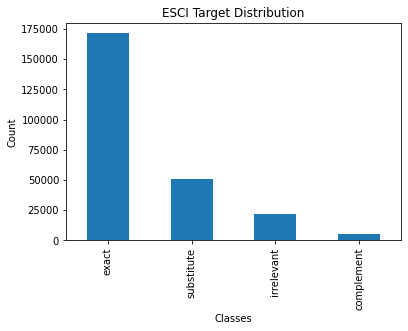

In [ ]:
us_train_product_modified_sampe_df.esci_label.value_counts().plot(kind='bar', title='ESCI Target Distribution', xlabel= 'Classes', ylabel = 'Count')
plt.show()

In [ ]:
us_train_product_modified_sampe_df['esci_label'].value_counts(normalize=True) * 100

exact         68.5888
substitute    20.3640
irrelevant     8.8420
complement     2.2052
Name: esci_label, dtype: float64

In [ ]:
# create length feature for query, product text
us_train_product_modified_sampe_df['length_product_text'] = us_train_product_modified_sampe_df['product_text'].apply(len)
us_train_product_modified_sampe_df['length_query'] = us_train_product_modified_sampe_df['query'].apply(len)
us_train_product_modified_sampe_df['length_product_text_modified'] = us_train_product_modified_sampe_df['product_text_modified'].apply(len)

In [ ]:
# checking for length of feature text to minimum 513
us_train_product_modified_sampe_df = us_train_product_modified_sampe_df[us_train_product_modified_sampe_df.length_product_text < 513]
us_train_product_modified_sampe_df = us_train_product_modified_sampe_df[us_train_product_modified_sampe_df.length_query < 513]
us_train_product_modified_sampe_df = us_train_product_modified_sampe_df[us_train_product_modified_sampe_df.length_product_text_modified < 513]

In [ ]:
us_train_product_modified_sampe_df

,example_id,query,product_id,esci_label,product_text,product_text_modified,length_product_text,length_query,length_product_text_modified
409188,658909,gender reveal smoke bombs,B07XH2LXBS,exact,gender reveal confetti powder mix cannons 36 i...,gender reveal confetti powder mix cannons 36 i...,219,25,174
765548,1015269,posada decorations,B078NQJDB1,exact,set 12 vibrant colorful hanging paper fans ros...,set 12 vibrant colorful hanging paper fans ros...,196,18,173
172631,422352,boys rollerblades light size 14,B00JR6KPXA,exact,chicago skates boys adjustable quad roller ska...,chicago skates boys adjustable quad roller ska...,93,31,74
822309,1072030,ruffle coats women,B07RC7P9NX,exact,karl lagerfeld paris womens garbine ruffle fro...,karl lagerfeld paris womens garbine ruffle fro...,100,18,73
880416,1130137,small toy kitchen,B085CBKMX8,exact,cute stone pretend play kitchen sink toys play...,cute stone pretend play kitchen sink toys cook...,185,17,163
...,...,...,...,...,...,...,...,...,...
1268782,1518503,tissa long bottle cleaning brush,B08G846XSF,exact,bottle brushes bottle brush cleaner pack 16 i...,bottle brushes brush cleaner pack 16 inch long...,199,32,185
900592,1150313,spray bottle car detailing,B07CJTCLDB,complement,mop mob leakfree acid resistant spray head 4 p...,mop mob leakfree acid resistant spray head 4 p...,193,26,185
236711,486432,cinnamon sticks potpourri,B074ZRFK2T,substitute,old candle barn pumpkin patch 4 cup bag putka...,old candle barn pumpkin patch 4 cup bag putka ...,138,25,114
733950,983671,pet nail grinder dogs,B07PFCLHKR,exact,casfuy dog nail grinder upgraded professional...,casfuy dog nail grinder upgraded professional ...,175,21,154


In [ ]:
# split traning and testing datasets
train_df, validation_df = train_test_split(us_train_product_modified_sampe_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_df

,example_id,query,product_id,esci_label,product_text,product_text_modified,length_product_text,length_query,length_product_text_modified
585953,835674,llama pajamas,B07RLTBJPD,substitute,rene rofe girls cozy polar fleece pajama pant ...,rene rofe girls cozy polar fleece pajama pant ...,95,13,78
521513,771234,joy,B08CKD61BT,exact,joypad controller replacement switchwireless s...,joypad controller replacement switchwireless s...,121,3,110
105428,355149,baby tutu,B077Z9HZDT,exact,muyan girls cotton tulle ruffle bow baby bloom...,muyan girls cotton tulle ruffle bow baby bloom...,105,9,94
509163,758884,isaih berlin,052183368X,exact,isaiah berlin letters 19281946 cambridge unive...,isaiah berlin letters 19281946 cambridge unive...,61,12,61
664597,914318,multivitamins men,B084PH9NSX,exact,one day men’s natural fruit bites multivitamin...,one day men’s natural fruit bites multivitamin...,95,17,87
...,...,...,...,...,...,...,...,...,...
736118,985839,phobe case samsung galaxy a6,B07WWWR9Z4,exact,leyi compatible samsung galaxy a6 case 2 pack ...,leyi compatible samsung galaxy a6 case 2 pack ...,182,28,155
289058,538779,decorative copper lights,B08YDN8GLH,exact,ehometronics string lights 1 pack 165ft 50 led...,ehometronics string lights 1 pack 165ft 50 led...,211,24,191
1037560,1287281,white masks,B08B4G1CP2,exact,10 pack soft ice cotton face protector mask wa...,10 pack soft ice cotton face protector mask wa...,119,11,109
734494,984215,peter rabbit book,0723277346,exact,peter rabbit library 10 books collection gift ...,peter rabbit library 10 books collection gift ...,57,17,53


In [ ]:
validation_df

,example_id,query,product_id,esci_label,product_text,product_text_modified,length_product_text,length_query,length_product_text_modified
512967,762688,jane green falling,1524700517,substitute,perfect mexican daughter ember tealturquoise g...,perfect mexican daughter ember tealturquoise g...,50,18,50
606384,856105,malden frames 8x10,B07F254SX6,exact,tasse verre 8x10 picture frame black 2pack w g...,tasse verre 8x10 picture frame black 2pack w g...,186,18,157
1053048,1302769,women scrubs,B072KHT3VC,exact,heartsoul break women scrubs pant low rise jog...,heartsoul break women scrubs pant low rise jog...,79,12,63
401730,651451,galvanized lag bolts,B074ZZ2KB3,exact,primeline 9057073 hex lag screws 12 in x 5 in ...,primeline 9057073 hex lag screws 12 in x 5 a30...,102,20,89
1214621,1464342,goddards silver polish foam,B01MZ6830C,substitute,goddards silver polish liquid tarnish remover ...,goddards silver polish liquid tarnish remover ...,70,27,61
...,...,...,...,...,...,...,...,...,...
507192,756913,iphone7case otterbox,B0777CSB77,exact,maxcury iphone 7 defender case iphone 8 case h...,maxcury iphone 7 defender case 8 heavy duty sh...,140,20,108
852356,1102077,shapeez,B07B42CDJJ,exact,silkee long nude largedd shapeez nude,silkee long nude largedd shapeez,39,7,32
1257656,1507377,belts young men,B00EYATQYS,exact,tommy hilfiger mens reversible belt blackbrown...,tommy hilfiger mens reversible belt blackbrown...,89,15,56
1060170,1309891,womens shirts blouses,B07MGPWKT3,exact,vetinee womens brown 34 bell sleeve shirt mesh...,vetinee womens brown 34 bell sleeve shirt mesh...,119,21,100


In [ ]:
train_df.isnull().sum()

example_id                      0
query                           0
product_id                      0
esci_label                      0
product_text                    0
product_text_modified           0
length_product_text             0
length_query                    0
length_product_text_modified    0
dtype: int64

# Model Training

In [ ]:
EPOCHS = 4

def accuracy(y_pred, y_test):
  accuracy = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return accuracy

def train(model, train_loader, test_loader, optimizer, path):  
  total_step = len(train_loader)
  epoch_train_loss = []
  epoch_train_acc = []

  for epoch in range(EPOCHS):
    start = time.time()

    # training
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

      acc = accuracy(prediction, labels)

      loss.backward()
      optimizer.step()
      
      total_train_loss += loss.item()
      total_train_acc  += acc.item()
    
    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_acc)

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} ')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

  torch.save(model.state_dict(), path)
  return model, epoch_train_loss, epoch_test_loss

## BERT Model

In [ ]:
class custom_data_bert(Dataset):

  def __init__(self, train_df, val_df):
    self.label_dict = {'exact': 0, 'substitute': 1, 'irrelevant': 2, 'complement': 3}

    self.train_df = train_df
    self.val_df = val_df

    self.base_path = '/content/'
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    self.train_data = None
    self.val_data = None
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)

  def load_data(self, df):
    MAX_LEN = 512 
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    query = df['query'].to_list()
    product_text = df['product_text'].to_list()
    esci_label = df['esci_label'].to_list()

    for (query, product_text, esci_label) in zip(query, product_text, esci_label):
      query_id = self.tokenizer.encode(query, add_special_tokens = False, max_length=512, truncation = True)
      product_text_id = self.tokenizer.encode(product_text, add_special_tokens = False, max_length=512, truncation = True)
      pair_token_ids = [self.tokenizer.cls_token_id] + query_id + [self.tokenizer.sep_token_id] + product_text_id + [self.tokenizer.sep_token_id]
      query_len = len(query_id)
      product_text_len = len(product_text_id)

      segment_ids = torch.tensor([0] * (query_len + 2) + [1] * (product_text_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (query_len + product_text_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[esci_label])
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=64, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader

In [ ]:
bert_dataset = custom_data_bert(train_df, validation_df)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

200000
50000


In [ ]:
train_loader_bert, test_loader_bert = bert_dataset.get_data_loaders(batch_size=64)

In [ ]:
model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
model_bert.to(device)

param_optimizer_bert = list(model_bert.named_parameters())
no_decay_bert = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters_bert = [
    {'params': [p for n, p in param_optimizer_bert if not any(nd in n for nd in no_decay_bert)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer_bert if any(nd in n for nd in no_decay_bert)],
     'weight_decay_rate': 0.0}
]

optimizer_bert = AdamW(optimizer_grouped_parameters_bert, lr=2e-5, correct_bias=False)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
path = '/content/drive/MyDrive/Amazon Shopping Queries Dataset/ Task 2: Multiclass Product Classification/bert_epoch4_May1_4:16pm.pth'

model_bert_trained, epoch_train_loss, epoch_test_loss = train(model_bert, train_loader_bert, test_loader_bert, optimizer_bert, path)

Epoch 1: train_loss: 0.6857 train_acc: 0.7296 
00:47:16.82
Epoch 2: train_loss: 0.5626 train_acc: 0.7854 
00:47:21.41
Epoch 3: train_loss: 0.4547 train_acc: 0.8307 
00:47:23.79
Epoch 4: train_loss: 0.3638 train_acc: 0.8662 
00:47:24.16


## ALBERT Model

In [ ]:
class custom_data_albert(Dataset):

  def __init__(self, train_df, val_df):
    self.label_dict = {'exact': 0, 'substitute': 1, 'irrelevant': 2, 'complement': 3}

    self.train_df = train_df
    self.val_df = val_df

    self.base_path = '/content/'
    self.tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
    self.train_data = None
    self.val_data = None
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)

  def load_data(self, df):
    MAX_LEN = 512 
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    query = df['query'].to_list()
    product_text = df['product_text'].to_list()
    esci_label = df['esci_label'].to_list()

    for (query, product_text, esci_label) in zip(query, product_text, esci_label):
      query_id = self.tokenizer.encode(query, add_special_tokens = False, max_length=512, truncation = True)
      product_text_id = self.tokenizer.encode(product_text, add_special_tokens = False, max_length=512, truncation = True)
      pair_token_ids = [self.tokenizer.cls_token_id] + query_id + [self.tokenizer.sep_token_id] + product_text_id + [self.tokenizer.sep_token_id]
      query_len = len(query_id)
      product_text_len = len(product_text_id)

      segment_ids = torch.tensor([0] * (query_len + 2) + [1] * (product_text_len + 1))
      attention_mask_ids = torch.tensor([1] * (query_len + product_text_len + 3)) 

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[esci_label])
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=64, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader

In [ ]:
albert_ds = custom_data_albert(train_df, validation_df)

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

200000
50000


In [ ]:
train_loader_albert, test_loader_albert = albert_ds.get_data_loaders(batch_size=64)

In [ ]:
model_albert = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=4)
model_albert.to(device)

param_optimizer_albert = list(model_albert.named_parameters())
no_decay_albert = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters_albert = [
    {'params': [p for n, p in param_optimizer_albert if not any(nd in n for nd in no_decay_albert)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer_albert if any(nd in n for nd in no_decay_albert)],
     'weight_decay_rate': 0.0}
]

optimizer_albert = AdamW(optimizer_grouped_parameters_albert, lr=2e-5, correct_bias=False)

Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [ ]:
path = '/content/drive/MyDrive/Amazon Shopping Queries Dataset/ Task 2: Multiclass Product Classification/albert_epoch4_may1_12:25.pth'

model_albert_trained, epoch_train_loss, epoch_test_loss = train(model_albert, train_loader_albert, test_loader_albert, optimizer_albert, path)

Epoch 1: train_loss: 0.8798 train_acc: 0.6864 
00:37:21.92
Epoch 2: train_loss: 0.7869 train_acc: 0.6903 
00:37:25.94
Epoch 3: train_loss: 0.7145 train_acc: 0.7123 
00:37:22.39
Epoch 4: train_loss: 0.6798 train_acc: 0.7387 
00:37:23.11


# Model Evaluation

In [ ]:
def testing(model,val_loader,optimizer):

  model.eval()
  total_val_acc  = 0
  total_val_loss = 0
  prediction_arr = []
  label_arr = []
  with torch.no_grad():
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)

      loss, prediction = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids, 
                            labels=labels).values()

      pred = torch.log_softmax(prediction, dim=1).argmax(dim=1)
      pred_decode = pred.cpu().data.numpy()
      for i in range(len(pred_decode)):
        prediction_arr.append(pred_decode[i])
      
      label_decode = labels.cpu().data.numpy()
      for j in range(len(label_decode)):
        label_arr.append(label_decode[j])

  return label_arr, prediction_arr

## Bert Testing

In [ ]:
path = "/content/Dataset csv/bert_epoch4_May1_4:16pm.pth"

model_bert.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
label_bert, prediction_bert = testing(model_bert,test_loader_bert,optimizer_bert)

print(classification_report(label_bert, prediction_bert, target_names=['exact','substitute', 'irrelevant', 'complement']))

              precision    recall  f1-score   support

       exact       0.87      0.91      0.89     34334
  substitute       0.65      0.63      0.64     10147
  irrelevant       0.67      0.51      0.58      4403
  complement       0.52      0.38      0.44      1116

    accuracy                           0.80     50000
   macro avg       0.67      0.61      0.64     50000
weighted avg       0.80      0.80      0.80     50000



## Albert Testing

In [ ]:
path = "/content/Dataset csv/albert_epoch4_may1_12:25.pth"

model_albert.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
label_albert, prediction_albert = testing(model_albert,test_loader_albert,optimizer_albert)

print(classification_report(label_albert, prediction_albert, target_names=['exact','substitute', 'irrelevant', 'complement']))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     34334
           1       0.48      0.45      0.46     10147
           2       0.45      0.35      0.40      4403
           3       0.00      0.00      0.00      1116

    accuracy                           0.73     50000
   macro avg       0.44      0.42      0.43     50000
weighted avg       0.70      0.73      0.71     50000



# **Demo**

In [ ]:
def get_predictions(query, product_text):

  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

  MAX_LEN = 512 
  token_ids = []
  mask_ids = []
  seg_ids = []

  query_id = tokenizer.encode(query, add_special_tokens = False, max_length=512, truncation = True)
  product_text_id = tokenizer.encode(product_text, add_special_tokens = False, max_length=512, truncation = True)
  pair_token_ids = [tokenizer.cls_token_id] + query_id + [tokenizer.sep_token_id] + product_text_id + [tokenizer.sep_token_id]
  query_len = len(query_id)
  product_text_len = len(product_text_id)

  segment_ids = torch.tensor([0] * (query_len + 2) + [1] * (product_text_len + 1))  # sentence 0 and sentence 1
  attention_mask_ids = torch.tensor([1] * (query_len + product_text_len + 3))  # mask padded values

  token_ids.append(torch.tensor(pair_token_ids))
  seg_ids.append(segment_ids)
  mask_ids.append(attention_mask_ids)

  token_ids = pad_sequence(token_ids, batch_first=True)
  mask_ids = pad_sequence(mask_ids, batch_first=True)
  seg_ids = pad_sequence(seg_ids, batch_first=True)

  token_ids = token_ids.to(device)
  mask_ids = mask_ids.to(device)
  seg_ids = seg_ids.to(device)

  return token_ids, mask_ids, seg_ids

def decode_label(prediction):
  labels = ["exact", "substitute", "irrelevant," "complement"]

  logits = prediction.logits
  predicted_label_classes = logits.argmax(-1)

  label_value = labels[predicted_label_classes]
  return label_value

In [ ]:
query = 'malden frames 8x10'
product_text = 'tasse verre 8x10 picture frame black 2pack w glass front cover displays 5x7 picture w mat 8x10” photo without mat vertical horizontal mounts easy hang hardware install tasse verre'

token_ids, mask_ids, seg_ids = get_predictions(query, product_text)

prediction = model_bert(token_ids, mask_ids, seg_ids)

predicted_label = decode_label(prediction)

print(predicted_label)

substitute
